### Installing all required Libraries

In [1]:
!pip install accelerate==0.21.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 2.1 MB/s eta 0:00:00


In [2]:
!pip install peft==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 853.8 kB/s eta 0:00:00


In [3]:
!pip install bitsandbytes==0.40.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 10.0 MB/s eta 0:00:00


In [4]:
!pip install transformers==4.31.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2


In [5]:
!pip install trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 917.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.6/301.6 kB 32.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstallin

### Import Required Libraries

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In case of Llama 2, the following prompt template is used for the chat models:

**System Prompt** (optional) to guide the model

**User prompt** (required) to give the instruction

**Model Answer** (required)


**System prompts** are used to provide context or additional information that guides the model's response. They can vary widely based on the application or platform.

Example System Prompt: "You are chatting with a virtual assistant trained to answer questions about technology. Please ask a question related to software development."

In this example, the system prompt sets the context that the user is interacting with a virtual assistant focused on technology-related questions.

**User prompts** are essential as they instruct the model on what information or response is expected. They frame the context for the model's generation.

Example User Prompt: "How can I optimize my code for performance in Python?"

**Model Answer (Generated):**
The model generates a response based on the provided prompts. This response should ideally address the user's query or instruction.

Example Model Answer: "To optimize your Python code for performance, consider using techniques such as optimizing loops with list comprehensions, using built-in functions like map() and filter(), and leveraging libraries like NumPy for numerical computations. Additionally, profiling your code with tools like cProfile can help identify bottlenecks and optimize accordingly."


**Conclusion:**
The prompt structure of System Prompt (optional), User Prompt (required), and Model Answer (required) provides a clear framework for interacting with pre-trained language models.







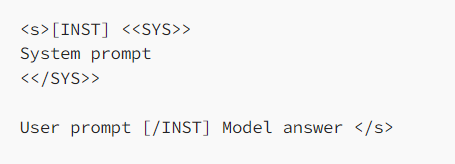

### Load the Model

1. Load a llama-2-7b-chat-hf model (chat model)
2. Train it on the Amod/mental_health_counseling_conversations, which will produce our fine-tuned model Llama-2-7b-chat-finetune

QLoRA will use a rank of 64 with a scaling parameter of 16. We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type and train it for one epoch

In [ ]:
model_name = "NousResearch/Llama-2-7b-chat-hf"

# The instruction dataset to use
dataset_name = "Amod/mental_health_counseling_conversations"

# Fine-tuned model name
new_model = "Llama-2-7b-chat-finetune"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

### Fine tuning

1. First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt, filter out bad text, combine multiple datasets, etc.

2. Then, we’re configuring bitsandbytes for 4-bit quantization.

3. Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.

4. Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!



In [ ]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train")

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Custom prompt template for Llama 2
def create_prompt(context, response):
    return f"[INST] {context} [/INST] {response}"

# Preprocess dataset to match the prompt template
def preprocess_function(examples):
    inputs = examples["Context"]
    targets = examples["Response"]
    return {"text": [create_prompt(inp, tgt) for inp, tgt in zip(inputs, targets)]}

# Apply preprocessing to the dataset
dataset = dataset.map(preprocess_function, batched=True)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()


In [ ]:
# Save trained model
trainer.model.save_pretrained(new_model)

In [ ]:
# Check the plots on tensorboard
%load_ext tensorboard
%tensorboard --logdir results/runs

In [ ]:
# Text generation pipeline with the new model
logging.set_verbosity(logging.CRITICAL)

# Example context (user input)
context = "I can't seem to feel any emotion except anxiety, not even for myself."

# Generate response
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"[INST] {context} [/INST]")
print(result[0]['generated_text'])

In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from peft import PeftModel

In [ ]:
# Device map for loading the model
device_map = {"": 0}

# Reload the base model in FP16 precision
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)

# Merge the base model with the fine-tuned LoRA weights
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Save the merged model
merged_model_dir = "Llama-2-7b-chat-merged"
model.save_pretrained(merged_model_dir)

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"
tokenizer.save_pretrained(merged_model_dir)

In [ ]:
# Load the merged model and tokenizer
merged_model_dir = "Llama-2-7b-chat-merged"
model = AutoModelForCausalLM.from_pretrained(merged_model_dir, torch_dtype=torch.float16).to("cuda")
tokenizer = AutoTokenizer.from_pretrained(merged_model_dir)

# Text generation pipeline with the merged model
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)

def generate_response(prompt, max_length=200):
    response = pipe(prompt, max_length=max_length, pad_token_id=tokenizer.eos_token_id)
    return response[0]['generated_text']

def format_prompt(context):
    return f"[INST] {context} [/INST]"

# Chatbot conversation loop
print("Chatbot is ready! Type 'exit' to end the conversation.")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'exit':
        break

    prompt = format_prompt(user_input)
    response = generate_response(prompt)
    print(f"Chatbot: {response}")

print("Conversation ended.")